In [1]:
import pandas as pd
import numpy as np

# Cargar el dataset
df = pd.read_csv("CSV_DEF.csv")

# Eliminar filas con clase 'Dispraxia'
df = df[df['variable'] != 'Dispraxia'].copy()

# Binarizar la variable objetivo
neurodiv = ["TDAH", "Autismo", "Dislexia"]
df["target"] = df["variable"].apply(lambda x: 1 if x in neurodiv else 0)

# Comprobaci√≥n
print("Distribuci√≥n de clases tras eliminar Dispraxia:")
print(df['variable'].value_counts())

# Mostrar distribuci√≥n de la variable binaria
print(df["target"].value_counts())
df[["variable", "target"]].head()

Distribuci√≥n de clases tras eliminar Dispraxia:
variable
Control     6155
Autismo     2113
TDAH        2030
Dislexia    2026
Name: count, dtype: int64
target
1    6169
0    6155
Name: count, dtype: int64


variable  target
0     TDAH       1
1     TDAH       1
2  Autismo       1
3  Autismo       1
4  Autismo       1

In [2]:
# 1. Eliminar columnas no num√©ricas o irrelevantes
cols_to_drop = [
    'created_at', 'aid', 'extension', 'format', 'duration',
    'FILE_STORED', 'FACIAL_ANALYSED', 'VOICE_ANALYSED', 'VOICE_TRANSCRIBED',
    'BIOMETRICS_EXTRACTED', 'SPEECH_ANALYSED', 'PERSONALITY_ANALYSED',
    'FACES_EXTRACTED', 'id', 'variable'  # variable ya est√° incluida como target
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 2. Eliminar columna con demasiados nulos
df.drop(columns=['dominant_emotion_counts_surprise'], inplace=True, errors='ignore')

# 3. Rellenar nulos por tipo de dato
columnas_con_nulos = df.columns[df.isnull().any()].tolist()

for col in columnas_con_nulos:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
        print(f"üü¶ Columna categ√≥rica '{col}' rellenada con su moda")

# 4. Comprobar que no quedan nulos
print("‚úÖ Nulos restantes tras limpieza:", df.isnull().sum().sum())

# 5. Separar X (predictoras) e y (target)
X = df.drop(columns='target')
y = df['target']

# Mostrar dimensiones finales
print(f"‚úÖ Dimensiones finales: X = {X.shape}, y = {y.shape}")

üü¶ Columna categ√≥rica 'most_frequent_dominant_emotion' rellenada con su moda
üü¶ Columna categ√≥rica 'voice_mean_note' rellenada con su moda
üü¶ Columna categ√≥rica 'voice_median_note' rellenada con su moda
üü¶ Columna categ√≥rica 'voice_mode_note' rellenada con su moda
üü¶ Columna categ√≥rica 'voice_Q25_note' rellenada con su moda
üü¶ Columna categ√≥rica 'voice_Q75_note' rellenada con su moda
üü¶ Columna categ√≥rica 'language' rellenada con su moda
‚úÖ Nulos restantes tras limpieza: 0
‚úÖ Dimensiones finales: X = (12324, 66), y = (12324,)


In [3]:
# Columnas categ√≥ricas con texto que hay que eliminar
columnas_categoricas = [
    'most_frequent_dominant_emotion',
    'voice_mean_note',
    'voice_median_note',
    'voice_mode_note',
    'voice_Q25_note',
    'voice_Q75_note',
    'language'
]

# Eliminar del conjunto X
X = X.drop(columns=columnas_categoricas, errors='ignore')

# Confirmamos las nuevas dimensiones
print(f"‚úÖ Nuevas dimensiones de X tras eliminar texto: {X.shape}")

‚úÖ Nuevas dimensiones de X tras eliminar texto: (12324, 59)


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Normalizaci√≥n
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Divisi√≥n en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

üìä Matriz de confusi√≥n:
 [[1099  433]
 [ 496 1053]]

üìã Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.69      0.72      0.70      1532
           1       0.71      0.68      0.69      1549

    accuracy                           0.70      3081
   macro avg       0.70      0.70      0.70      3081
weighted avg       0.70      0.70      0.70      3081

üßÆ AUC: 0.7568704310200972


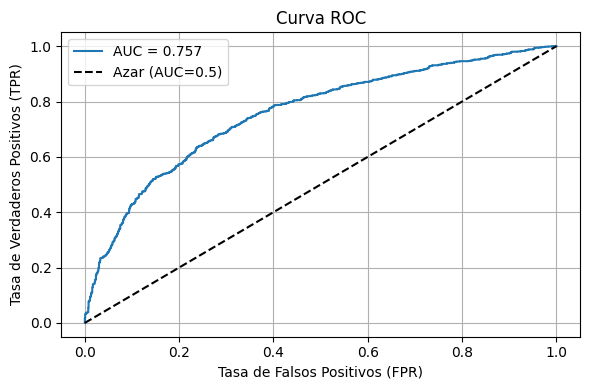

In [14]:
# 3. Entrenamiento
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Predicciones y evaluaci√≥n
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y_test, y_pred))
print("\nüìã Clasificaci√≥n:\n", classification_report(y_test, y_pred))
print("üßÆ AUC:", roc_auc_score(y_test, y_prob))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Crear copia de X_train como DataFrame con √≠ndices de y_train
X_train_df = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)

# A√±adir constante
X_train_df = sm.add_constant(X_train_df)

# Entrenar modelo logit
logit_model = sm.Logit(y_train, X_train_df).fit()

# Mostrar resultados
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.592964
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 9243
Model:                          Logit   Df Residuals:                     9183
Method:                           MLE   Df Model:                           59
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                  0.1445
Time:                        09:58:39   Log-Likelihood:                -5480.8
converged:                       True   LL-Null:                       -6406.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0270      0.023      1.163      0.245      -0.019   

----

Optimization terminated successfully.
         Current function value: 0.686901
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12316
Method:                           MLE   Df Model:                            7
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                0.009010
Time:                        10:12:00   Log-Likelihood:                -8465.4
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                 6.046e-30
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0036      0.018      0.198      0.843      -0.032       0.039
angry_facial  

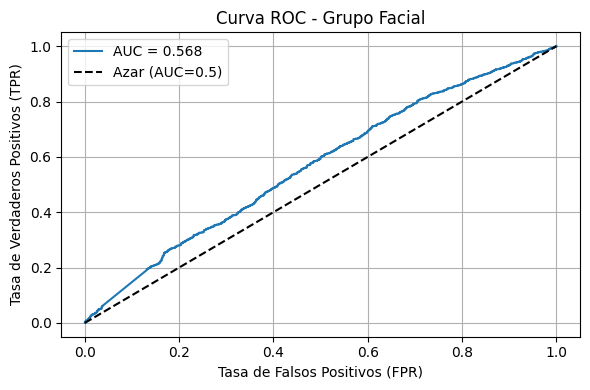

üìä Matriz de confusi√≥n:
 [[4155 2000]
 [3709 2460]]


In [24]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Variables faciales
facial_cols = [
    'angry_facial', 'disgust_facial', 'fear_facial', 'happy_facial',
    'sad_facial', 'surprise_facial', 'neutral_facial'
]

# 2. Preparar X e y
X_facial = df[facial_cols]
y = df["target"]

# 3. Normalizaci√≥n
scaler = StandardScaler()
X_facial_scaled = scaler.fit_transform(X_facial)

# 4. Crear DataFrame alineado con y
X_facial_df = pd.DataFrame(X_facial_scaled, columns=facial_cols, index=y.index)
X_facial_df = sm.add_constant(X_facial_df)

# 5. Modelo logit
logit_model = sm.Logit(y, X_facial_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_facial_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Facial')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y, y_prob > 0.5))

üìã Interpretaci√≥n de cada variable
Nota: Como todas las variables fueron normalizadas (z-score), sus coeficientes pueden compararse directamente. Coeficientes negativos indican que un mayor valor disminuye la probabilidad de neurodivergencia, y positivos que la aumenta.

| Variable          | Coef.  | p-valor | Significativa | Interpretaci√≥n                                                             |
| ----------------- | ------ | ------- | ------------- | -------------------------------------------------------------------------- |
| `angry_facial`    | -0.229 | <0.001  | ‚úÖ             | A mayor expresi√≥n de enfado, menor probabilidad de neurodivergencia.       |
| `disgust_facial`  | +0.019 | 0.342   | ‚ùå             | No tiene un efecto estad√≠sticamente significativo.                         |
| `fear_facial`     | -0.171 | <0.001  | ‚úÖ             | M√°s miedo facial se asocia a menor neurodivergencia.                       |
| `happy_facial`    | -0.248 | <0.001  | ‚úÖ             | Mayor expresi√≥n de felicidad reduce la probabilidad.                       |
| `sad_facial`      | -0.184 | <0.001  | ‚úÖ             | M√°s tristeza facial tambi√©n reduce la probabilidad.                        |
| `surprise_facial` | +0.056 | 0.018   | ‚úÖ             | Aumenta ligeramente la probabilidad de neurodivergencia.                   |
| `neutral_facial`  | -0.261 | <0.001  | ‚úÖ             | Una expresi√≥n m√°s neutra se asocia fuertemente con menor neurodivergencia. |


Todas las emociones reconocidas facialmente est√°n negativamente asociadas con neurodivergencia, salvo la sorpresa, que tiene una peque√±a contribuci√≥n positiva.
Esto podr√≠a reflejar que las personas neurodivergentes, en este conjunto de datos, tienden a mostrar menos expresividad emocional facial o una expresi√≥n m√°s neutra.
La excepci√≥n de surprise_facial sugiere que ciertas emociones como la sorpresa podr√≠an comportarse diferente, pero su efecto es menor.

Optimization terminated successfully.
         Current function value: 0.651326
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12311
Method:                           MLE   Df Model:                           12
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                 0.06033
Time:                        10:11:42   Log-Likelihood:                -8026.9
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                4.504e-213
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0045      0.019      0.242      0.809      -0.032       0.041
extraver

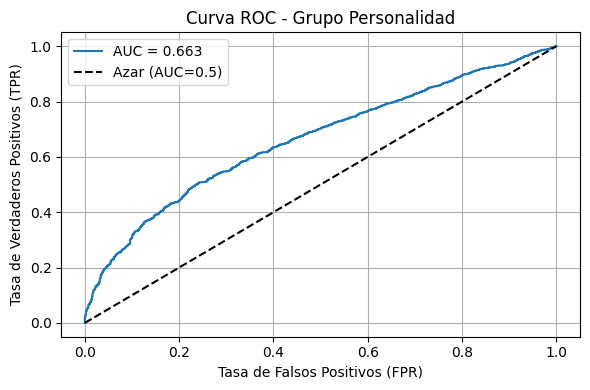

üìä Matriz de confusi√≥n:
 [[3845 2310]
 [2376 3793]]


In [23]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Variables de personalidad
personality_cols = [
    'extraversion', 'neuroticism', 'agreeableness',
    'conscientiousness', 'openness', 'survival', 'creativity',
    'self_esteem', 'compassion', 'communication',
    'imagination', 'awareness'
]

# 2. Preparar X e y
X_personality = df[personality_cols]
y = df["target"]

# 3. Normalizaci√≥n
scaler = StandardScaler()
X_personality_scaled = scaler.fit_transform(X_personality)

# 4. Crear DataFrame alineado con y
X_personality_df = pd.DataFrame(X_personality_scaled, columns=personality_cols, index=y.index)
X_personality_df = sm.add_constant(X_personality_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_personality_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_personality_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Personalidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y, y_prob > 0.5))

üìà AUC: 0.663
Mejor que el grupo facial (0.568).

Esto indica que las caracter√≠sticas de personalidad aportan m√°s informaci√≥n predictiva sobre la probabilidad de neurodivergencia.

üìã Variables significativas:
| Variable            | Coef.      | Interpretaci√≥n                                                                                                                                           |
| ------------------- | ---------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `extraversion`      | **+0.662** | Mayor extraversi√≥n ‚Üí **mayor** probabilidad de neurodivergencia. Sorprendente, podr√≠a reflejar sesgo en el dataset o diferencias de estilo de expresi√≥n. |
| `neuroticism`       | **‚Äì0.212** | A mayor neuroticismo ‚Üí **menor** probabilidad.                                                                                                           |
| `agreeableness`     | **+0.195** | M√°s amabilidad ‚Üí mayor probabilidad.                                                                                                                     |
| `conscientiousness` | **+0.398** | Mayor responsabilidad/autocontrol ‚Üí mayor probabilidad.                                                                                                  |
| `openness`          | **‚Äì0.506** | M√°s apertura a experiencias ‚Üí menor probabilidad.                                                                                                        |
| `survival`          | **‚Äì0.219** | Tendencia a priorizar lo b√°sico ‚Üí menor probabilidad.                                                                                                    |
| `creativity`        | **‚Äì0.056** | Creatividad ligeramente reduce la probabilidad.                                                                                                          |


Optimization terminated successfully.
         Current function value: 0.663983
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12311
Method:                           MLE   Df Model:                           12
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                 0.04207
Time:                        10:13:56   Log-Likelihood:                -8182.9
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                4.135e-146
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0107      0.019      0.575      0.565      -0.026       0.047

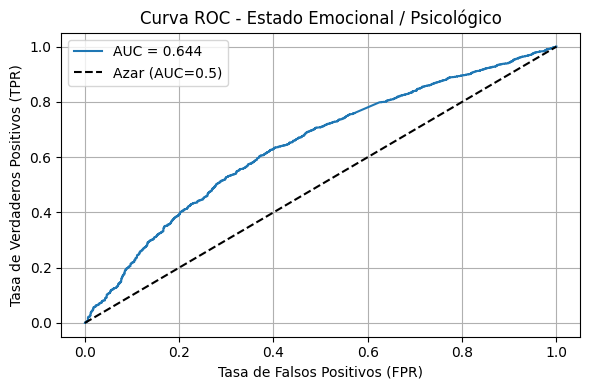

üìä Matriz de confusi√≥n:
 [[4345 1810]
 [2977 3192]]


In [25]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables de estado emocional
mental_state_cols = [
    'stress_high', 'stress_medium', 'stress_low',
    'helplessness_high', 'helplessness_medium', 'helplessness_low',
    'self_efficacy_high', 'self_efficacy_medium', 'self_efficacy_low',
    'depression_high', 'depression_medium', 'depression_low'
]

# 2. Preparar X e y
X_mental = df[mental_state_cols]
y = df["target"]

# 3. Normalizaci√≥n
scaler = StandardScaler()
X_mental_scaled = scaler.fit_transform(X_mental)

# 4. Crear DataFrame alineado con y
X_mental_df = pd.DataFrame(X_mental_scaled, columns=mental_state_cols, index=y.index)
X_mental_df = sm.add_constant(X_mental_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_mental_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_mental_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Estado Emocional / Psicol√≥gico')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusi√≥n
print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y, y_prob > 0.5))

üß† An√°lisis del grupo emocional/psicol√≥gico
üìà AUC: 0.644
Mejor que el grupo facial (0.568), pero algo por debajo del de personalidad (0.663).

Este grupo aporta buena capacidad predictiva.

Refuerza que los rasgos emocionales y de bienestar est√°n correlacionados con neurodivergencia en este dataset.

üìã Variables significativas:
| Variable               | Coef.  | Interpretaci√≥n                                                                |
| ---------------------- | ------ | ----------------------------------------------------------------------------- |
| `stress_medium`        | ‚Äì0.962 | Estr√©s medio disminuye probabilidad de neurodivergencia.                      |
| `helplessness_low`     | +0.655 | Baja indefensi√≥n ‚Üí mayor probabilidad. Curioso, probablemente efecto cruzado. |
| `self_efficacy_medium` | +0.401 | Nivel medio de autoeficacia se asocia a mayor probabilidad.                   |
| `self_efficacy_high`   | +0.618 | Nivel alto de autoeficacia tambi√©n aumenta probabilidad.                      |
| `depression_medium`    | ‚Äì0.508 | Depresi√≥n media reduce la probabilidad.                                       |
| `depression_low`       | ‚Äì0.384 | Depresi√≥n baja tambi√©n reduce probabilidad.                                   |


Optimization terminated successfully.
         Current function value: 0.679878
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12311
Method:                           MLE   Df Model:                           12
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                 0.01914
Time:                        10:15:56   Log-Likelihood:                -8378.8
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                 9.709e-63
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0055      0.018      0.300      0.764      -0.030       0.041
voice_mean       

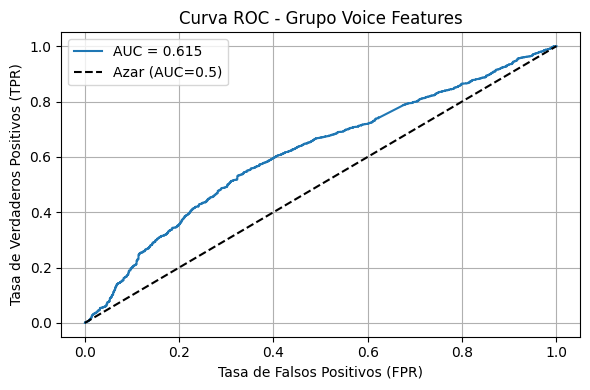

üìä Matriz de confusi√≥n:
 [[3625 2530]
 [2428 3741]]


In [26]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables vocales
voice_cols = [
    'voice_mean', 'voice_sd', 'voice_median', 'voice_mode',
    'voice_Q25', 'voice_Q75', 'voice_IQR',
    'voice_skewness', 'voice_kurtosis', 'voice_rmse',
    'pitch', 'tone'
]

# 2. Preparar X e y
X_voice = df[voice_cols]
y = df["target"]

# 3. Normalizaci√≥n
scaler = StandardScaler()
X_voice_scaled = scaler.fit_transform(X_voice)

# 4. Crear DataFrame alineado con y
X_voice_df = pd.DataFrame(X_voice_scaled, columns=voice_cols, index=y.index)
X_voice_df = sm.add_constant(X_voice_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_voice_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_voice_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Voice Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusi√≥n
print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y, y_prob > 0.5))


üéôÔ∏è An√°lisis del grupo de caracter√≠sticas vocales
üìà AUC = 0.615
Algo mejor que azar puro y m√°s informativo que el grupo facial (0.568).

Sin embargo, menos predictivo que personalidad (0.663) y emocional (0.644).

Esto sugiere que la manera de hablar tiene cierto valor diagn√≥stico, pero no es tan discriminativa por s√≠ sola.

üìã Variables estad√≠sticamente significativas:
| Variable       | Coef.  | Interpretaci√≥n                                                            |
| -------------- | ------ | ------------------------------------------------------------------------- |
| `voice_mean`   | +0.373 | Mayor promedio de frecuencia ‚Üí mayor probabilidad de neurodivergencia.    |
| `voice_sd`     | +0.334 | M√°s variabilidad en la se√±al vocal ‚Üí mayor probabilidad.                  |
| `voice_median` | +0.896 | Mediana de voz alta ‚Üí indicador positivo.                                 |
| `voice_mode`   | ‚Äì0.083 | Contrario al anterior, m√°s valor modal de voz reduce la probabilidad.     |
| `voice_Q25`    | +1.101 | Percentil 25 alto (tonos bajos) ‚Üí mayor probabilidad.                     |
| `voice_Q75`    | ‚Äì6.978 | Percentil 75 alto (tonos altos) ‚Üí **fuerte disminuci√≥n** de probabilidad. |
| `voice_IQR`    | +6.556 | Mayor rango intercuart√≠lico ‚Üí m√°s neurodivergencia.                       |
| `voice_rmse`   | ‚Äì0.217 | Mayor error cuadr√°tico de la se√±al (menos suave) ‚Üí menor probabilidad.    |


Optimization terminated successfully.
         Current function value: 0.678503
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12315
Method:                           MLE   Df Model:                            8
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                 0.02113
Time:                        10:18:15   Log-Likelihood:                -8361.9
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                 4.214e-73
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0057      0.018      0.310      0.757      -0.030       0.042
sad_voice     

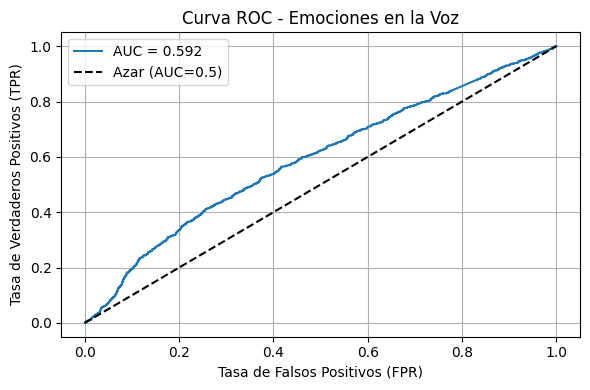

üìä Matriz de confusi√≥n:
 [[4440 1715]
 [3520 2649]]


In [28]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables emocionales de la voz
voice_emotion_cols = [
    'sad_voice', 'disgust_voice', 'fearful_voice', 'neutral_voice',
    'happy_voice', 'angry_voice', 'calm_voice', 'surprised_voice'
]

# 2. Preparar X e y
X_voice_emotion = df[voice_emotion_cols]
y = df["target"]

# 3. Normalizaci√≥n
scaler = StandardScaler()
X_voice_emotion_scaled = scaler.fit_transform(X_voice_emotion)

# 4. Crear DataFrame alineado con y
X_voice_emotion_df = pd.DataFrame(X_voice_emotion_scaled, columns=voice_emotion_cols, index=y.index)
X_voice_emotion_df = sm.add_constant(X_voice_emotion_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_voice_emotion_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_voice_emotion_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Emociones en la Voz')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusi√≥n
print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y, y_prob > 0.5))


üó£Ô∏è An√°lisis del grupo Voice Emotions
üìà AUC = 0.592
Mejor que azar (0.5), pero el menos predictivo de todos los grupos hasta ahora.

Sugiere que las emociones percibidas en la voz aportan algo, pero son insuficientes por s√≠ solas para detectar neurodivergencia con precisi√≥n.

üìã Variables significativas:
| Variable        | Coef.      | Interpretaci√≥n                                                                |
| --------------- | ---------- | ----------------------------------------------------------------------------- |
| `sad_voice`     | **+0.370** | A mayor nivel de tristeza en la voz ‚Üí mayor probabilidad de neurodivergencia. |
| `fearful_voice` | **+0.072** | Ligera asociaci√≥n positiva con neurodivergencia.                              |
| `neutral_voice` | **+0.097** | M√°s voz neutral ‚Üí mayor probabilidad.                                         |
| `happy_voice`   | **+0.187** | Sorpresivamente, m√°s alegr√≠a vocal tambi√©n aumenta la probabilidad.           |
| `calm_voice`    | **+0.181** | M√°s calma tambi√©n asociada positivamente.                                     |

‚ö†Ô∏è Nota: Todas las emociones significativas tienen coeficiente positivo, lo cual es llamativo. Puede reflejar que el modelo capta uso m√°s marcado o variable de emociones en personas neurodivergentes, o que estas emociones no son excluyentes entre s√≠ (es decir, una voz puede ser calmada y triste a la vez).

Optimization terminated successfully.
         Current function value: 0.673272
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12316
Method:                           MLE   Df Model:                            7
Date:                Wed, 04 Jun 2025   Pseudo R-squ.:                 0.02867
Time:                        10:20:16   Log-Likelihood:                -8297.4
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                1.210e-101
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0105      0.018      0.571      0.568      -0.026      

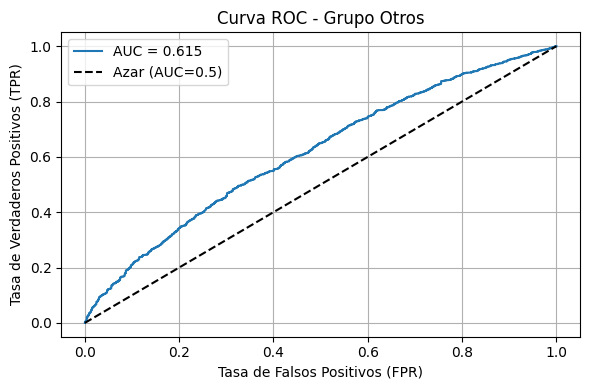

üìä Matriz de confusi√≥n:
 [[3605 2550]
 [2676 3493]]


In [30]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables del grupo "otros"
other_cols = [
    'no_speech_prob', 'entropy',
    'tense_past', 'tense_present', 'tense_future',
    'sentiment_polarity', 'sentiment_subjectivity'
]

# 2. Preparar X e y
X_other = df[other_cols]
y = df["target"]

# 3. Normalizaci√≥n
scaler = StandardScaler()
X_other_scaled = scaler.fit_transform(X_other)

# 4. Crear DataFrame alineado con y
X_other_df = pd.DataFrame(X_other_scaled, columns=other_cols, index=y.index)
X_other_df = sm.add_constant(X_other_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_other_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_other_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Otros')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusi√≥n
print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y, y_prob > 0.5))


üì¶ An√°lisis del grupo ‚ÄúOtros‚Äù
Este grupo incluye m√©tricas de estilo ling√º√≠stico, uso del lenguaje y se√±ales generales del contenido de voz.

üìà AUC = 0.615
Igual que el grupo de Voice Features (0.615).

Superior al azar (0.5), pero modesto por s√≠ solo.

Esto indica que algunos patrones en el contenido y estructura del habla pueden tener relaci√≥n con neurodivergencia, pero de forma d√©bil si se toman aislados.

üìã Variables significativas:
| Variable         | Coef.  | Interpretaci√≥n                                                                                  |
| ---------------- | ------ | ----------------------------------------------------------------------------------------------- |
| `no_speech_prob` | ‚Äì0.194 | A mayor probabilidad de no haber habla en el audio, **menor** probabilidad de neurodivergencia. |
| `entropy`        | ‚Äì0.251 | A menor entrop√≠a (m√°s estructura en el discurso), **mayor** probabilidad de neurodivergencia.   |
| `tense_past`     | ‚Äì0.290 | Uso del pasado reduce la probabilidad.                                                          |
| `tense_present`  | ‚Äì0.176 | Uso del presente tambi√©n la reduce.                                                             |
| `tense_future`   | ‚Äì0.202 | Hablar del futuro tambi√©n reduce probabilidad.                                                  |


____

## Comparativa de grupos: capacidad predictiva (Logit Models)

| Grupo                   | N¬∫ Variables | AUC   | Variables Significativas (`p < 0.05`) | Observaciones clave                                                                                          |
| ----------------------- | ------------ | ----- | ------------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **Facial**              | 7            | 0.568 | 6 de 7                                | Todas las emociones significativas (negativas), excepto sorpresa. Menor expresividad ‚Üí m√°s neurodivergencia. |
| **Personalidad**        | 12           | 0.663 | 7 de 12                               | `extraversion`, `conscientiousness`, y `openness` destacan. Grupo m√°s predictivo.                            |
| **Estado emocional**    | 12           | 0.644 | 5 de 12                               | `stress_medium`, `self_efficacy_high`, `depression_medium`... varios patrones complejos.                     |
| **Voice Features**      | 12           | 0.615 | 7 de 12                               | `voice_median`, `IQR`, `Q25`, `Q75`... tono y modulaci√≥n importantes.                                        |
| **Voice Emotions**      | 8            | 0.592 | 5 de 8                                | `sad_voice`, `neutral_voice`, `calm_voice`... emociones vocales √∫tiles, pero d√©biles solas.                  |
| **Otros (ling√º√≠stico)** | 7            | 0.615 | 5 de 7                                | `entropy`, `tense_*`, `no_speech_prob` significativos. Refleja estructura narrativa.                         |

---

## Conclusiones generales

1. **Grupo m√°s predictivo individualmente**: `üü¢ Personalidad` (AUC = 0.663)
2. **Grupos complementarios √∫tiles**: `Estado emocional`, `Voice Features`, y `Otros`
3. **Grupo menos informativo solo**: `Facial` (aunque con varias variables muy significativas)
4. **Muchas variables se solapan en l√≥gica**: baja entrop√≠a, menor expresividad, mayor autocontrol...

---

## Que hacer
Odds Ratios?